In [1]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

In [2]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['query'],
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["label"][0]
                }
            ],
        },
    ]

In [3]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'val[:10%]', 'test[:10%]'])

In [4]:
train_dataset

Dataset({
    features: ['image', 'query', 'label', 'human_or_machine'],
    num_rows: 2830
})

In [5]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [6]:
train_dataset[200]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=308x369>},
   {'type': 'text',
    'text': 'Is the rightmost value of light brown graph 58?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'No'}]}]

In [25]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, Qwen2_5_VLProcessor
from qwen_vl_utils import process_vision_info

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

In [8]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': 'Yes'}]}]

In [10]:
train_dataset[0][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

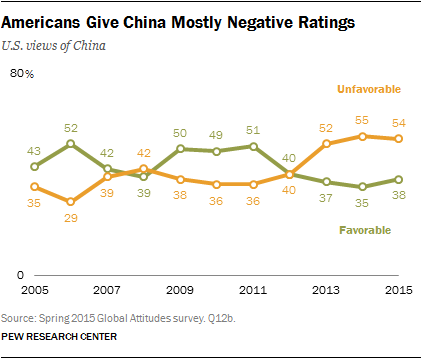

In [11]:
train_dataset[0][1]['content'][0]['image']

In [12]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2],  # Use the sample without the system message
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [13]:
# Example of how to call the method with sample:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

'Yes, the value of "Favorable" is 38 in 2015 according to the provided data.'

In [14]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 7.57 GB


## train

In [15]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


In [17]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-trl-sft-ChartQA",  # Directory to save the model
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=1,  # Batch size for training
    per_device_eval_batch_size=1,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    tf32=True,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=True,  # Whether to push model to Hugging Face Hub
    report_to="wandb",  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    #max_seq_length=1024  # Maximum sequence length for input
)

training_args.remove_unused_columns = False  # Keep unused columns in dataset

In [18]:
import wandb

wandb.init(
    project="qwen2-3b-instruct-trl-sft-ChartQA",  # change this
    name="qwen2-3b-instruct-trl-sft-ChartQA_2",  # change this
    config=training_args,
)

wandb: Currently logged in as: miguel_kjh to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
    # Ignore the image token index in the loss computation (model specific)
    #if isinstance(processor, Qwen2_5_VLProcessor):  # Check if the processor is Qwen2VLProcessor
    #    image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    #else:
    #    image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

In [20]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
)

/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/miguel/miniconda3/envs/vqa/lib/python3.11/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
10,3.851400,3.196943
20,2.758700,2.332792
30,1.963000,1.418920
40,1.038000,0.681980
50,0.627100,0.519097
60,0.502600,0.442057
70,0.432500,0.396544
80,0.409200,0.375607
90,0.406800,0.365149
100,0.389800,0.357257


TrainOutput(global_step=1059, training_loss=0.4097844680825757, metrics={'train_runtime': 10482.4709, 'train_samples_per_second': 0.81, 'train_steps_per_second': 0.101, 'total_flos': 9.252876741992448e+16, 'train_loss': 0.4097844680825757})

In [22]:
trainer.save_model(training_args.output_dir)

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


In [23]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 7.58 GB


## testing finetune

In [26]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2_5_VLProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
adapter_path = "qwen2-7b-instruct-trl-sft-ChartQA"
model.load_adapter(adapter_path)

In [28]:
train_dataset[0][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=422x359>},
   {'type': 'text', 'text': 'Is the value of Favorable 38 in 2015?'}]}]

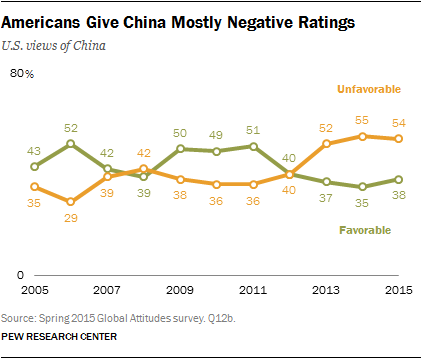

In [29]:
train_dataset[0][1]['content'][0]['image']

In [30]:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

'Yes'

In [34]:
test_dataset[11][:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a Vision Language Model specialized in interpreting visual data from chart images.\nYour task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.\nThe charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.\nFocus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=850x600>},
   {'type': 'text',
    'text': 'What is the difference in value between Green bar and Orange bar?'}]}]

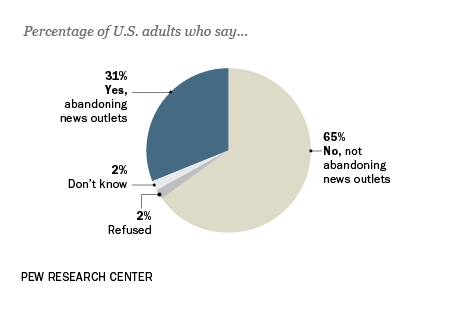

In [54]:
question_id = 15
test_dataset[question_id][1]['content'][0]['image']

In [55]:
print("Prompt:", test_dataset[question_id][:2][1]['content'][1]['text'])

Prompt: Two segments have the same percentage value, what's that value?


In [56]:
output = generate_text_from_sample(model, processor, test_dataset[question_id])
print("VLM output:", output)
print("Expected output:", test_dataset[question_id][2]['content'][0]['text'])

VLM output: The two segments with the same percentage value are "Refused" and "Don't know," both at 2%.
Expected output: 2


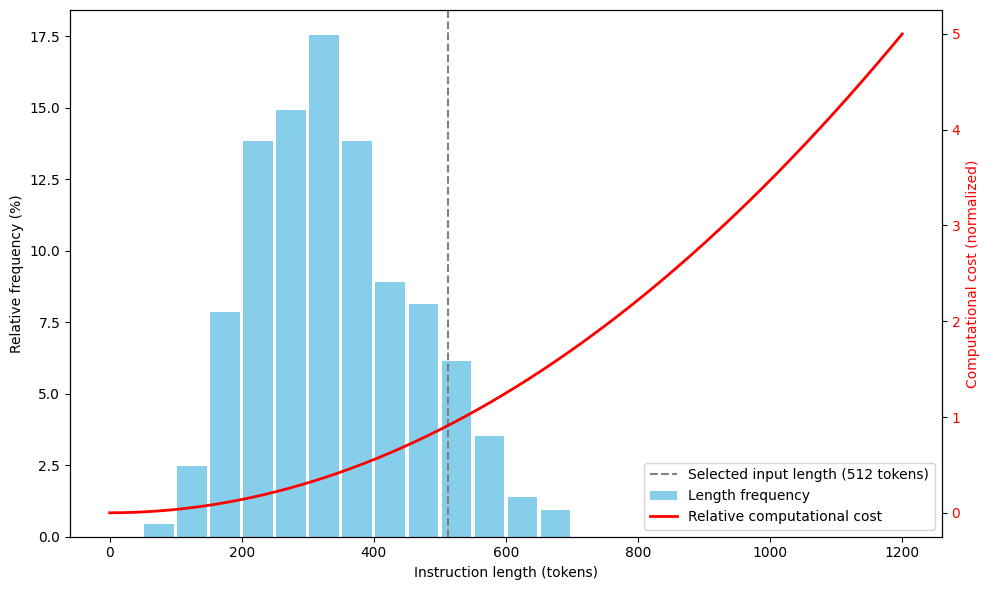

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Simulación de longitudes (microdocumento + microsummary), centradas en 387 tokens
np.random.seed(42)
microdoc_lengths = np.concatenate([
    np.random.normal(loc=295, scale=90, size=500),
    np.random.normal(loc=500, scale=80, size=150)
])
microdoc_lengths = np.clip(microdoc_lengths, 50, 1200)  # eliminamos casos <50

# Histograma
bins = np.arange(0, 1250, 50)
hist_vals, bin_edges = np.histogram(microdoc_lengths, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
freq_percent = hist_vals / hist_vals.sum() * 100

# Curva de coste computacional (normalizada)
context_lengths = np.linspace(0, 1200, 500)
cost_curve = (context_lengths**2) / (1200**2) * 5  # escalada a máx 5

# Crear figura
fig, ax1 = plt.subplots(figsize=(10, 6))

# Histograma de frecuencias relativas
ax1.bar(bin_centers, freq_percent, width=45, color='skyblue', label='Length frequency')
ax1.set_xlabel('Instruction length (tokens)')
ax1.set_ylabel('Relative frequency (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Curva de coste computacional (eje secundario)
ax2 = ax1.twinx()
ax2.plot(context_lengths, cost_curve, color='red', linewidth=2, label='Relative computational cost')
ax2.set_ylabel('Computational cost (normalized)', color='red')

ax2.tick_params(axis='y', labelcolor='red')

# Línea vertical en 512 tokens
ax1.axvline(x=512, color='gray', linestyle='--', label='Selected input length (512 tokens)')

# Leyenda combinada
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='lower right')

# Título
#plt.title('Distribution of Instruction Length')

plt.tight_layout()
#plt.grid()
plt.show()


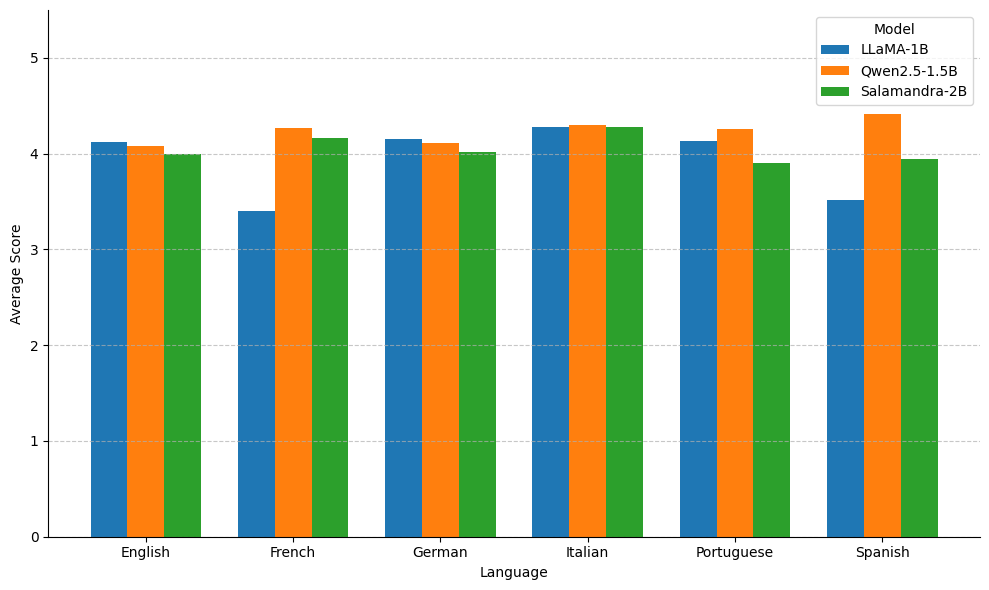

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Datos aproximados extraídos visualmente de la gráfica
languages = ['English', 'French', 'German', 'Italian', 'Portuguese', 'Spanish']
llama_scores = [4.12, 3.40, 4.15, 4.28, 4.13, 3.52]
qwen_scores = [4.08, 4.27, 4.11, 4.30, 4.26, 4.41]
salamandra_scores = [4.00, 4.16, 4.02, 4.28, 3.90, 3.94]

# Posiciones para las barras
x = np.arange(len(languages))
width = 0.25

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 6))

# Dibujar las barras con colores más visibles y patrones de relleno
bars1 = ax.bar(x - width, llama_scores, width, label='LLaMA-1B', color='#1f77b4')
bars2 = ax.bar(x, qwen_scores, width, label='Qwen2.5-1.5B', color='#ff7f0e')
bars3 = ax.bar(x + width, salamandra_scores, width, label='Salamandra-2B', color='#2ca02c')

# Añadir etiquetas y título
ax.set_xlabel('Language')
ax.set_ylabel('Average Score')
#ax.set_title('Mean Human Evaluation per Model and Language (Eurlex)')
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title="Model", loc='upper right')

# Mostrar la gráfica
plt.tight_layout()
plt.ylim(0, 5.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


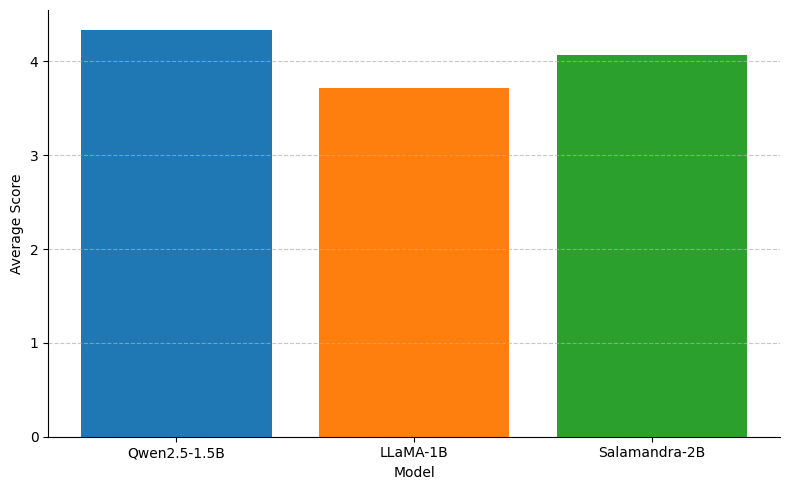

In [4]:
# Datos aproximados extraídos visualmente de la gráfica
models = ['Qwen2.5-1.5B', 'LLaMA-1B', 'Salamandra-2B']
scores = [4.33, 3.72, 4.07]

# Posiciones de las barras
x = np.arange(len(models))

# Crear la figura
fig, ax = plt.subplots(figsize=(8, 5))

# Dibujar las barras con colores más visibles y patrones de relleno
bars = ax.bar(x, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Añadir etiquetas y título
ax.set_xlabel('Model')
ax.set_ylabel('Average Score')
#ax.set_title('Average Evaluation Score per Model (Canary Islands Parliament)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(models)

# Quitar la leyenda
ax.legend_.remove() if ax.legend_ else None

# Ajustar el diseño
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
